<a href="https://colab.research.google.com/github/dviva1972/denvlaiva/blob/master/DLL_HW_14_1_text_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DLL

## Домашняя работа 13 | Работа с текстом / Трансформеры

## Иванов Денис

Решить задачу перевода с использованием трансформеров

Возьмите англо-испанские пары фраз (www.manythings.org....org/anki/)

Обучите на них seq2seq with transformers

### 1. Импорт библиотек / данных

In [1]:
from io import open
import unicodedata
import string
import re
import random
import math
import numpy as np
from collections import Counter

import torch as tr
import torch.nn as nn
from   torch import Tensor
from   torch.nn import Transformer
import torch.nn.functional as F

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
DEVICE = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
print(f"work on {(tr.cuda.get_device_name() if DEVICE.type == 'cuda' else 'cpu')}")

work on Tesla P100-PCIE-16GB


### 2. Импорт и предобработка текста

In [3]:
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip

--2021-10-17 05:19:14--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5192744 (5.0M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.95M  --.-KB/s    in 0.07s   

2021-10-17 05:19:14 (73.9 MB/s) - ‘spa-eng.zip’ saved [5192744/5192744]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


Для решения задачи принят следующий алгоритм подготовки данных:

*   в качестве единицы / наблюдения анализа принято 1 предложение, разделенное окончанием пары фраз или знаками окончания предложения '.!?' 
*   предложение - не более  20 слов, если более - предложение обрезается, к анализу берется 20 первых слов
*   в случае, если в исходной паре фраз содержится несколько предложений - то количество наблюдений по паре фраз соответствует количеству отдельных предложений к переводу
*   в случае, если в исходной паре фраз количество предложений на входе не совпадает с количеством предложений на выходе - такая пара фраз в обучении модели не участвует
*   в случае, если хотя бы в одном из пары предложений встречаются редкие слова (встречающиеся по всему корпусу исходных данных менее 5 раз) - такая пара фраз в обучении модели не участвует

In [4]:
SOS_token   = 'SOS'
EOS_token   = 'EOS'
lang1       = 'eng'
lang2       = 'spa'

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {'<pad>': 0, SOS_token: 1, EOS_token: 2}
        self.index2word = {0: '<pad>', 1: SOS_token, 2: EOS_token}
        self.word2count = {}
        self.n_words = 3 

    def addSentence(self, sentence):
        for word in sentence:#.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
           if unicodedata.category(c) != 'Mn')

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-ЯёЁ.!?]+", r" ", s)
    return s

In [6]:
def readLangs(s_limit):
    print("Reading lines...")
    lines = open('spa.txt', encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in re.split('\t', l)] for l in lines]
    pairs_list = []
    for string in pairs:
        eng_split =  [i for i in re.split('[\.!?]', string[0]) if i != '']
        esp_split =  [i for i in re.split('[\.!?]', string[1]) if i != '']    
        if len(eng_split) ==  len(esp_split):
            for i in range(len(eng_split)):            
                eng_s = re.findall('[\w]+', eng_split[i])[:s_limit]
                esp_s = re.findall('[\w]+', esp_split[i])[:s_limit]
                pairs_list.append([eng_s, esp_s]) 
    return pairs_list

In [7]:
def prepareData(i_lang, o_lang, se_limit):
    pairs     = readLangs(se_limit)
    inp_lang  = Lang(i_lang)
    out_lang  = Lang(o_lang)
    print("Read %s sentence pairs" % len(pairs))
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        inp_lang.addSentence(pair[0])
        out_lang.addSentence(pair[1])
    print("Counted words:")
    print(inp_lang.name, inp_lang.n_words)
    print(out_lang.name, out_lang.n_words)
    return inp_lang, out_lang, pairs

In [8]:
def Prepare_Filt_Data(im_lang = lang1, ou_lang = lang2, 
                      sen_limit = 20,  w_limit = 5):
    i1_lang, o1_lang, pairs=prepareData(im_lang, ou_lang, sen_limit)
    inp_lang_  = Lang(im_lang)
    out_lang_  = Lang(ou_lang)

    eng_words_select = set([i for i in i1_lang.word2count.keys() 
                               if i1_lang.word2count[i] > w_limit])
    esp_words_select = set([i for i in o1_lang.word2count.keys() 
                               if o1_lang.word2count[i] > w_limit])
    
    for pair in pairs:
        for wrd_i in pair[0]:
            if wrd_i in eng_words_select:
                inp_lang_.addWord(wrd_i)
        for wrd_o in pair[1]:
            if wrd_o in esp_words_select:
                out_lang_.addWord(wrd_o)

    print('Using filter: every dict word in sentenses > ', w_limit)
    print(inp_lang_.name, inp_lang_.n_words)
    print(out_lang_.name, out_lang_.n_words)

    pairs_select = []
    for i in range(len(pairs)):
        if all(word in eng_words_select for word in pairs[i][0]):
            if all(word in esp_words_select for word in pairs[i][1]):
                   pairs_select.append([pairs[i][0], pairs[i][1]]) 

    print(len(pairs_select), ' sentenses')
    return inp_lang_, out_lang_, pairs_select

In [9]:
input_lang, output_lang, pairs =  Prepare_Filt_Data(sen_limit = 20,  
                                                    w_limit   = 5)

Reading lines...
Read 135511 sentence pairs
Trimmed to 135511 sentence pairs
Counting words...
Counted words:
eng 13489
spa 26094
Using filter: every dict word in sentenses >  5
eng 4998
spa 7106
101567  sentenses


In [10]:
full_len   = len(pairs)
train_list = random.sample(range(full_len),   int(round(full_len*0.85, 0)))
test_list  = list((Counter(range(full_len)) - Counter(train_list)).elements())

In [11]:
def get_batch(pairs_num_list, batch_size):
    batch_list = random.sample(pairs_num_list, batch_size)
    Max_src_len, Max_tgt_len = 20, 20
    inp_matrix = np.zeros((batch_size, Max_src_len))
    out_matrix = np.zeros((batch_size, Max_tgt_len))
    training_pairs = []
    batch_pairs  = []

    for a in range(batch_size):
        sent_in = pairs[batch_list[a]][0]
        for b in range(len(sent_in)+2):
            if b == 0:
                inp_matrix[a][b] = 1
            elif b < len(sent_in):
                inp_matrix[a][b] = input_lang.word2index[sent_in[b-1]]
            elif (b==len(sent_in) and b< Max_src_len-1) or b==Max_src_len-1:
                inp_matrix[a][b] = 2
            else:
                break

        sent_out = pairs[batch_list[a]][1]
        for b in range(len(sent_in)+2):
            if b == 0:
                out_matrix[a][b] = 1
            elif b < len(sent_out):
                out_matrix[a][b] = output_lang.word2index[sent_out[b-1]]
            elif (b==len(sent_out) and b < Max_tgt_len-1) or b==Max_tgt_len-1:
                out_matrix[a][b] = 2
            else:
                break

        data   = tr.tensor(inp_matrix, dtype=tr.long, device=DEVICE)
        target = tr.tensor(out_matrix, dtype=tr.long, device=DEVICE)
        training_pairs.append([data, target])

    return training_pairs

### 3. Архитектура сети

#### 3.1. Positional Encoder

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.5, max_len=7000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = tr.zeros(max_len, d_model)
        position = tr.arange(0, max_len, dtype=tr.float).unsqueeze(1)
        div_term = tr.exp(tr.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = tr.sin(position * div_term)
        pe[:, 1::2] = tr.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

#### 3.2. Transformer

In [13]:
class Trans1(tr.nn.Module):
    def __init__(self, n_classes_in, n_classes_out, 
                 n_emb, n_layers = 4, activ = tr.nn.LeakyReLU, 
                 dropout: float = 0.5):
        super().__init__()
        self.emb_srs = tr.nn.Embedding(n_classes_in, n_emb)
        self.emb_tgt = tr.nn.Embedding(n_classes_out, n_emb)
        self.trans = tr.nn.Transformer(n_emb, num_encoder_layers = n_layers, 
                                       num_decoder_layers = n_layers, 
                                       dropout = dropout)

        self.pos_encoder = PositionalEncoding(n_emb)
        self.fc  = tr.nn.Linear(n_emb, n_classes_out)

    def forward(self, srs, tgt):            
        srs = self.emb_srs(srs)
        tgt = self.emb_tgt(tgt)

        srs = self.pos_encoder(srs)
        tgt = self.pos_encoder(tgt)

        x = self.trans(srs, tgt)
        x = self.fc(x)

        return x

#### 3.3. Train

In [14]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0    
    train_data = get_batch(train_list, 100)
    for i, [src, tgt] in enumerate(train_data):
        src         = src.squeeze().to(DEVICE)
        tgt         = tgt.squeeze().to(DEVICE)
        optimizer.zero_grad() 
        pred        = transformer(src, tgt)           
        loss        = loss_fn(pred.reshape(-1, n_classes_out), tgt.reshape(-1))
        losses += loss.item()
        loss.backward()
        optimizer.step()
    return losses / len(train_data)


def evaluate(model):
    model.eval()
    losses      = 0
    val_data    = get_batch(test_list, 10)
    for i, [src, tgt] in enumerate(val_data):
        src         = src.squeeze().to(DEVICE)
        tgt         = tgt.squeeze().to(DEVICE)        
        pred        = transformer(src, tgt)           
        loss        = loss_fn(pred.reshape(-1, n_classes_out), tgt.reshape(-1))
        losses += loss.item()
    return losses / len(val_data)

### 4. Обучение модели

In [15]:
n_classes_in  = input_lang.n_words
n_classes_out = output_lang.n_words
n_emb         = 128
n_layers      = 2

transformer   = Trans1(n_classes_in, n_classes_out, n_emb, n_layers)
transformer   = transformer.to(DEVICE)
loss_fn       = tr.nn.CrossEntropyLoss()
optimizer     = tr.optim.Adam(transformer.parameters(), lr=0.0000009) 

In [16]:
n_iters       = 400
step          = 20
loss_items    = []
loss_values   = []
start_time = timer()

for epoch in range(1, n_iters+1):    
    train_loss = train_epoch(transformer, optimizer)
    end_time   = timer()
    val_loss   = evaluate(transformer)
    loss_items.append(epoch)
    loss_values.append(train_loss)
    if epoch in range(0, n_iters, step):
        end_time   = timer()
        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
        start_time = timer()

Epoch: 20, Train loss: 4.868, Val loss: 3.711, Epoch time = 40.404s
Epoch: 40, Train loss: 4.177, Val loss: 3.289, Epoch time = 40.217s
Epoch: 60, Train loss: 3.626, Val loss: 3.058, Epoch time = 40.237s
Epoch: 80, Train loss: 3.145, Val loss: 2.623, Epoch time = 40.240s
Epoch: 100, Train loss: 2.731, Val loss: 2.169, Epoch time = 40.235s
Epoch: 120, Train loss: 2.333, Val loss: 2.194, Epoch time = 40.217s
Epoch: 140, Train loss: 2.077, Val loss: 2.011, Epoch time = 40.240s
Epoch: 160, Train loss: 1.774, Val loss: 1.691, Epoch time = 40.210s
Epoch: 180, Train loss: 1.565, Val loss: 1.423, Epoch time = 40.234s
Epoch: 200, Train loss: 1.348, Val loss: 1.887, Epoch time = 40.212s
Epoch: 220, Train loss: 1.244, Val loss: 1.095, Epoch time = 40.223s
Epoch: 240, Train loss: 1.138, Val loss: 1.344, Epoch time = 40.225s
Epoch: 260, Train loss: 1.108, Val loss: 0.938, Epoch time = 40.226s
Epoch: 280, Train loss: 0.977, Val loss: 1.097, Epoch time = 40.224s
Epoch: 300, Train loss: 0.955, Val los

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

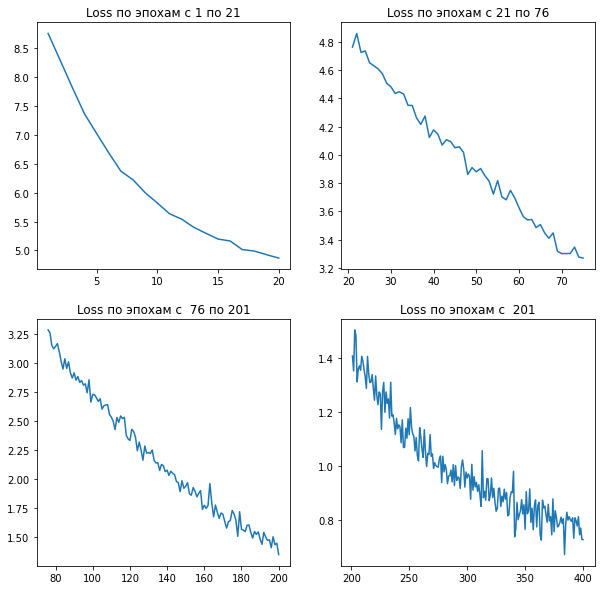

In [17]:
diskr_iters = [20, 75, 200, 400]

fig, ((ax_1, ax_2), 
      (ax_3, ax_4)
    )  = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

ax_1.set_title('Loss по эпохам с 1 по ' + str(loss_items[diskr_iters[0]]))
sns.lineplot([loss_items[i]  for i in  range(diskr_iters[0])], 
             [loss_values[i] for i in  range(diskr_iters[0])],
              ax = ax_1)

ax_2.set_title('Loss по эпохам с ' + str(loss_items[diskr_iters[0]]) + 
               ' по ' + str(loss_items[diskr_iters[1]]))
sns.lineplot([loss_items[i]  for i in  range(diskr_iters[0], diskr_iters[1])], 
             [loss_values[i] for i in  range(diskr_iters[0], diskr_iters[1])],
             ax = ax_2)

ax_3.set_title('Loss по эпохам с  '+ str(loss_items[diskr_iters[1]])+ 
               ' по ' + str(loss_items[diskr_iters[2]]))
sns.lineplot([loss_items[i]  for i in  range(diskr_iters[1], diskr_iters[2])], 
            [loss_values[i] for i in  range(diskr_iters[1], diskr_iters[2])],
             ax = ax_3)

ax_4.set_title('Loss по эпохам с  '+ str(loss_items[diskr_iters[2]]))
sns.lineplot([loss_items[i]  for i in  range(diskr_iters[2], diskr_iters[3])], 
            [loss_values[i]  for i in  range(diskr_iters[2], diskr_iters[3])],
             ax = ax_4)

plt.show()